# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 

This example normalizes by the baseline of each trial, for that data needs to be loaded per trial which is slower. To speed up use a global baseline if possible (i.e. pass `frames_average` with 3 dimensions (ch,w,h) or set `onsets` to None).

Subtracting the baseline per trial helps dealing with slow drifts in fluorescence.

In [1]:
from wfieldtools import *

localdisk = 'd:\\temp_folder'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]
frames_average = np.load(pjoin(localdisk,'frames_average.npy'))
trial_onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))

dat = mmap_dat(dat_path) # load to memory if you have enough
onsets = trial_onsets['iframe']

U,SVT = approximate_svd(dat, frames_average,onsets = onsets)
np.save(pjoin(localdisk,'Ua.npy'),U)
np.save(pjoin(localdisk,'SVTa.npy'),SVT)

Computing SVT from the raw data: 100%|██████████| 413/413 [04:24<00:00,  1.56it/s]


In [13]:
# Look at the difference between the reconstructed and the raw data
itrial = 400
ii = (onsets[itrial],onsets[itrial+1])
nframes = ii[1]-ii[0]
mov = reconstruct(U,SVT[:,ii[0]*2:ii[0]*2+nframes*2],
                  dims = dat.shape[-2:]).reshape(nframes,2,*dat.shape[-2:])
avg =  get_trial_baseline(ii[0],frames_average,onsets)
napari_show((mov*avg)+avg - dat[ii[0]:ii[1]])

In [35]:
# Explore the reconstructed dataset
napari_show(mov)

<Figure size 432x288 with 0 Axes>

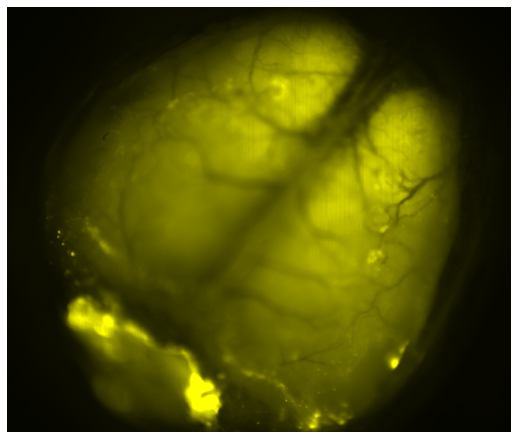

<Figure size 432x288 with 0 Axes>

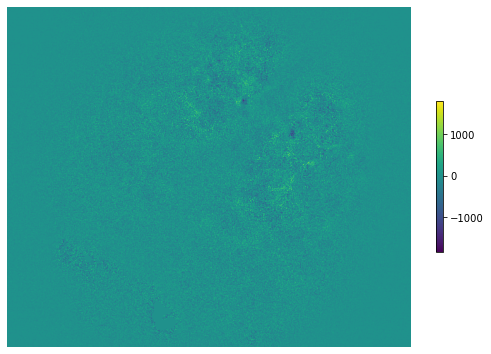

In [33]:
# Compare single frames
%matplotlib inline
# green is raw; red is reconstructed
check = np.stack([((mov[0]*avg)+avg)[0],
                  dat[ii[0],0]])
plt.figure();
imshow_noborder(two_chan_to_rgb(check));
plt.figure();
imshow_noborder(np.diff(check,axis=0).squeeze());
plt.colorbar(shrink = 0.3);

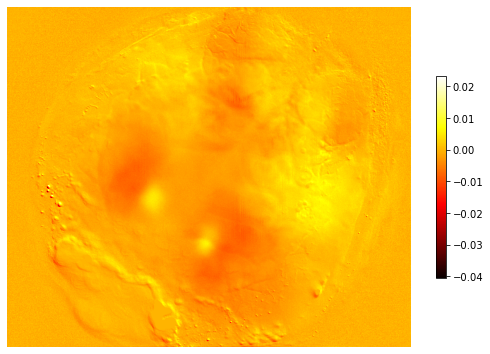

In [34]:
imshow_noborder(reconstruct(U,SVT[:,400],dims = dat.shape[-2:]).squeeze(),
                cmap = 'hot');
plt.colorbar(shrink = .4)